# 1a)  IMPORTING AND CLEANING THE DATA

In [1]:
import pandas as pd
import os
import re
import tldextract
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial
import os, time, http.client
from termcolor import colored
import sys
import json
from pygments import highlight, lexers, formatters
import pycountry

In [88]:
# Tools for visualizing the data

# requires jupytertehmes

%pylab inline
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='paper', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

# reset default matplotlib rcParams
jtplot.reset()

Populating the interactive namespace from numpy and matplotlib


In [2]:
#iclabcombined = pd.read_csv("combined.csv", dtype={'country' : str})

Dropping the columns which were meant for internal use of ICLAB team and the header columns which have come into dataset via join

In [3]:
# iclabcombined.drop(['filename', 'as_number'], axis=1, inplace= True)

# iclabcombined.drop([ 3078134,  4235577, 12411076, 18967078, 25041685, 26600938,
#             28192530, 29460039, 30795516, 32569776, 34391850, 36093972,
#             37793956, 39298313, 40934970, 42276914, 42976448, 44455181,
#             47068048, 49383978], inplace = True)

Correcting wrongly coded boolean values in the datasets

In [4]:
# iclabcombined['dns'].replace('false',False,inplace=True)
# iclabcombined['dns_all'].replace('false',False,inplace=True)
# iclabcombined['block'].replace('false',False,inplace=True)
# iclabcombined['packet_updated'].replace('false',False,inplace=True)
# iclabcombined['censored_updated'].replace('false',False,inplace=True)

# iclabcombined['dns'].replace('true',True,inplace=True)
# iclabcombined['dns_all'].replace('true',True,inplace=True)
# iclabcombined['block'].replace('true',True,inplace=True)
# iclabcombined['packet_updated'].replace('true',True,inplace=True)
# iclabcombined['censored_updated'].replace('true',True,inplace=True)

# 1b) Importing categories

In [5]:
# catDF = pd.read_fwf('type_domain_mapping.txt',header=None, names=[ "Name"], sep="")

In [6]:
# catDF = catDF.Name.apply(lambda x: pd.Series(str(x).split("|||"))).rename(columns={0:'category',1:'site'})

In [7]:
# allCategories = set(catDF['category'])
# len(allCategories)

In [8]:
# ADDING CATEGORY AS A PERMANENT COLUMN

# urlListAll = iclabcombined['url'].tolist()
# sitesListAll = []

# for item in urlListAll:
#     domainAll = tldextract.extract(item)[1]
#     suffixAll = tldextract.extract(item)[2]
#     sitesListAll.append(domainAll + "." + suffixAll)

In [9]:
# iclabcombined['site'] = sitesListAll
# iclabcombined = pd.merge(iclabcombined, catDF, on='site',how='left')

In [10]:
# PICKLING OUR DATA FOR FASTER ACCESS
#iclabcombined.to_pickle('iclabcombined.pkl')

==
LOADING DATA FRAME FROM PICKLE==

In [30]:
iclabcombined = pd.read_pickle('../data//iclab_cleaned_data/iclabCLEAN.pkl')

In [47]:
print("The number of observations in our original data set are {0} and the number of features/columns are {1} ".format(iclabcombined.shape[0],iclabcombined.shape[1]))

The number of observations in our original data set are 40303928 and the number of features/columns are 17 


In [48]:
iclabcombined['category'] = iclabcombined['category'].fillna(0)

In [49]:
iclabcombined['category']=iclabcombined['category'].replace(0,'Undefined')

In [50]:
iclabcombined.head()

,server_t,country,schedule_name,url,dns,dns_reason,dns_all,dns_reason_all,http_status,block,body_len,http_reason,packet_updated,packet_reason,censored_updated,site,category
0,2017-01-01T00:03:55.797Z,UA,alexa-global,4shared.com,False,sameip,False,NaN,200,False,89694,NaN,NaN,NaN,False,4shared.com,File Sharing and Storage
1,2017-01-01T00:03:55.797Z,UA,alexa-global,quora.com,-2,no_control_resp,False,NaN,200,False,99907,NaN,NaN,NaN,False,quora.com,Reference
2,2017-01-01T00:03:55.797Z,UA,alexa-global,stackexchange.com,-2,no_control_resp,False,NaN,200,False,83096,NaN,NaN,NaN,False,stackexchange.com,Information Technology
3,2017-01-01T00:03:55.797Z,UA,alexa-global,whatsapp.com,-2,no_control_resp,False,NaN,200,False,32799,NaN,NaN,NaN,False,whatsapp.com,Instant Messaging
4,2017-01-01T00:03:55.797Z,UA,alexa-global,atlassian.net,-2,no_control_resp,False,NaN,200,False,38180,NaN,NaN,NaN,False,atlassian.net,Information Technology


# -====- IN THE LATEST ITERATION OF THIS NOTEBOOK, NO FALSE POSITIVIES i.e. NO DATA FOR US HAS BEEN DROPPED -====-

# 2. ANALYZING FALSE POSITIVES  (REDUNDANT SECTION)

In [51]:
# #function to find blocked URLs
# def blockedURLs(cc):
#     return (set(iclabcombined[ (iclabcombined['country']== cc)& ((iclabcombined['censored_updated']==True)) ]['url']))

### 2a) Looking at sites which only have censored_updated = True

The below query produces 167 urls, these are the URLs for which the ICLab team believes the packets might have been injected i.e. becuase there was a response after RST or FIN or maybe because of ICMP admin prohibited i.e. they determined there's a firewall that blocks a connection. Removing these from our data as these are cases of PROBABLE CENSORSHIP and not ACTUAL censorship

In [52]:
#( set(iclabcombined[ (iclabcombined['country']=='US')  & ((iclabcombined['dns']== False) & (iclabcombined['dns_all']== False) & (iclabcombined['block']== False) & (iclabcombined['packet_updated']== True))]['url']))

Even urls for which a 4xx or 5xx result was returned are accessible and some of them are URLS commonly accessed in US

In [53]:
# set(iclabcombined
#     [ (iclabcombined['country']=='US') 
#                    & 
#      (
#          (iclabcombined['http_status']== 403.0) | (iclabcombined['http_status']== 404.0) | (iclabcombined['http_status']== 504.0)
#      )
#      &
#      (   
#                        (iclabcombined['dns']== False) & (iclabcombined['dns_all']== False)
#                        & (iclabcombined['block']== False) & (iclabcombined['dns_all']== False) 
#                        & (iclabcombined['packet_updated']== True)
#                    )]
#      ['url'])

In [54]:
#httpError = np.arange(400,600,1,dtype=float)

The falsePositIndex here are the sites which return a http 200 and only show packet_updated = True. In below query, I eliminate the countries where the result of HTTP was not a 400/500 errorand the only mechanism of censorship was that the packet_updated = True i.e. all these are probable censorships

In [55]:
# falsePositIndex = iclabcombined[
#     (~iclabcombined.http_status.isin(httpError))  
#                    & (   (iclabcombined['dns']== False) & (iclabcombined['dns_all']== False) & (iclabcombined['block']== False) & (iclabcombined['dns_all']== False) & (iclabcombined['packet_updated']== True)
#                      )] [['country','url','http_status']].index.tolist()

In [56]:
# print("We have " + str(len(falsePositIndex)) + " probable censoriships which could be false positives")

In [57]:
# iclabcombined.drop(falsePositIndex,inplace=True)

Now having a look at FALSE NEGATIVES
We define false negatives as websites which are showing censored_updated = False here but upon testing actually are inaccessible

In [58]:
# set(iclabcombined[(iclabcombined['country']=='US')&(iclabcombined['censored_updated']==False) & (iclabcombined.http_status.isin([403.0]))]['url'])

In total as seen below we have 3389 websites which show up as not censored in US but the corresponding HTTP results are error codes, manual testing of these websites show that they are accessible, its not possible to actually determine the status of all false negatives. Based on our testing and seeing that they are not marked as blocked eventually and also because we believe that false negatives are not too critical to our project  $hence$ $we$ $wont$ $drop$ $them$ $from$ $the$ $data$ $set$

## 2b) Removing the FALSE POSITIVIES (US blocked sites) from our main dataset iclabcombined

From this data looking at the sites that are shown as censored in US. THESE SITES HAVE CENSORED = TRUE AND RETURN A HTTP ERROR

In [59]:
#set( iclabcombined  [  (iclabcombined['country']=='US') & (iclabcombined.http_status.isin(httpError) & ( (iclabcombined['dns_all']== True) | (iclabcombined['block']== True)|(iclabcombined['censored_updated']== True) | (iclabcombined['packet_updated']== True)))]['url'])

In [24]:
# SITES SHOWING HTTP status reason as block in US but still accessible
#set( iclabcombined  [  (iclabcombined['country']=='US') & (iclabcombined.http_reason.str.contains('block'))]['url'])

Overall all the above results show a very dirty data, we basically removed the root urls of all the sites that show 404 in US and then checked how many of them are accesible. There are no patterns while some are showing as blocked on testing others are not. BELOW WE REMOVE THESE FALSE POSITIVIES FROM THE US

In [25]:
#USFPlist = (iclabcombined [(iclabcombined['country']=='US') & (iclabcombined['censored_updated'] == True)]['site']).unique().tolist()

In [26]:
#USblockIclab = len(iclabcombined[iclabcombined['site'].isin(USFPlist)])

In [27]:
# print("There are {} unique blocked websites in the US".format(len(USFPlist)))
# print("There are {} total observations of these blocked websites throughout our dataset".format(USblockIclab))

In [28]:
# USFPIndex is the index of all those observations for the unique sites which are blocked in US and we are going to remove from the entire DB
#USFPIndex = iclabcombined[iclabcombined['site'].isin(USFPlist)].index

# iclabCLEAN is our cleaned dataframe

In [29]:
#iclabCLEAN = iclabcombined.drop(USFPIndex)

## PICKLING OUR CLEAN DATASET FOR FASTER ACCESS

In [30]:
#iclabCLEAN.to_pickle('iclabCLEAN.pkl')

In [31]:
# LOADING DATA FRAME FROM PICKLE
#iclabCLEAN = pd.read_pickle('iclabCLEAN.pkl')

In [32]:
# COMPARNING DATA SIZES of RAW and CLEAN DATA 
#print("The number of observations in our original data set are {0} and the number of features/columns are {1} ".format(iclabcombined.shape[0],iclabcombined.shape[1]))
#print("The number of observations in our CLEANED data set i.e. without sites blocked in USA are {0} and the number of features/columns are {1} ".format(iclabCLEAN.shape[0],iclabCLEAN.shape[1]))

$******************************************************************$

# 3.  EXPERIMENT 1

Looking at the exact webpages blocked

In [33]:
# blockpageTR = set(iclabCLEAN[(iclabCLEAN['country']=='TR') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['url'])
# len(blockpageTR)

In [34]:
# blockpageRU = set(iclabCLEAN[(iclabCLEAN['country']=='RU') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['url'])
# len(blockpageRU)

In [35]:
# RUblockpageTR = blockpageTR.intersection(blockpageRU)
# RUblockpageTR

# EXPERIMENT 2

In [36]:
# blockIN = set(iclabCLEAN[(iclabCLEAN['country']=='IN') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockIN)

In [37]:
# blockCN = set(iclabCLEAN[(iclabCLEAN['country']=='CN') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockCN)

In [38]:
# blockVN = set(iclabCLEAN[(iclabCLEAN['country']=='VN') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockVN)

In [39]:
# blockRU = set(iclabCLEAN[(iclabCLEAN['country']=='RU') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True)| (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True))]['site'])
# len(blockRU)

In [40]:
# blockTR = set(iclabCLEAN[(iclabCLEAN['country']=='TR') & ((iclabCLEAN['dns_all']==True)| (iclabCLEAN['censored_updated']==True) | (iclabCLEAN['block']==True) | (iclabCLEAN['packet_updated']==True)) ]['site'])
# len(blockTR)

In [41]:
# blockNL = set(iclabCLEAN[(iclabCLEAN['country']=='NL') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockNL)

In [42]:
# blockNZ = set(iclabCLEAN[(iclabCLEAN['country']=='NZ') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockNZ)

In [43]:
# AU_NZ = blockNZ.intersection(blockAU)
# len(AU_NZ)

In [44]:
# blockMX = set(iclabCLEAN[(iclabCLEAN['country']=='MX') & ((iclabCLEAN['censored_updated']==True))]['site'])
# len(blockMX)

In [45]:
# IN_RU = blockIN.intersection(blockRU)
# (IN_RU)

Intersections as per EXPERIMENT 2

In [46]:
# RU_TR = blockRU.intersection(blockTR)

In [47]:
# BR_MX = blockMX.intersection(blockBR)

In [48]:
# NL_TR = blockNL.intersection(blockTR)

As part of Experiment 2 : 
(a) A look at censored FB Pages in India

Looking at worldwide distribution of FB blocking

In [49]:
# iclabCLEAN[iclabCLEAN['url'].str.contains('facebook')].groupby('country').count()

Looking at FB pages censored in India

In [50]:
# fbIndBlock = set (iclabcombined [ ( (iclabcombined['block']== True) | (iclabcombined['censored_updated']== True) | (iclabcombined['packet_updated']== True) ) & (iclabcombined['url'].str.contains('facebook')) & (iclabcombined['country']=='IN') ]['url'])
# fbIndBlock

(b) A look into religious censorship in the world

In [20]:
# iclabCLEAN[ (iclabCLEAN['category'].isin(['Global Religion','Alternative Beliefs'])) & ( (iclabCLEAN['block']== True) | (iclabCLEAN['censored_updated'] == True) ) ].groupby(['country', 'site']).first()

# 4) EXPERIMENT 3 : 

----------Defining a function which computes contribution of each category in a countries blocked sites--------

In [60]:
def Category_contributions(cc):
    catDataCC = iclabcombined[(iclabcombined['country']==cc) & (iclabcombined['censored_updated']==True) ]
    catDataCC= catDataCC.drop(['server_t', 'censored_updated','site','dns_all','packet_reason','url','dns','dns_reason','dns_reason_all','schedule_name','http_status','block','body_len','http_reason','packet_updated'], axis=1)
    catDataCC = catDataCC.groupby('category').count()
    catDataCC['%Cat'] = (catDataCC['country']*100)/(catDataCC['country'].sum())
    catDataCC= catDataCC.reset_index().drop('country',axis=1)
    catDataCC= catDataCC.rename(columns={'country':'Number of sites in' + str(cc),'%Cat':cc})
    return catDataCC

In [22]:
#Category_contributions('US')

In [54]:
#Category_contributions('CA')

In [55]:
# INplot = Category_contributions('IN')
# display(INplot)
# TRplot =Category_contributions('TR')
# RUplot = Category_contributions('RU')
# KRplot= Category_contributions('KR')
# USplot = Category_contributions('US')
# CNplot = Category_contributions('CN')
# CAplot  = Category_contributions('CA')
# ZAplot  = Category_contributions('ZA')

 Plotting the graph below:

In [56]:
# graphcompare1 = pd.merge(INplot,TRplot, on='category', how='outer')
# graphcompare2 = pd.merge(graphcompare1,KRplot, on='category', how='outer')
# graphcompare3 = pd.merge(graphcompare2,RUplot, on='category', how='outer')
# graphcompare4 = pd.merge(graphcompare3,USplot, on='category', how='outer')
# graphcompare5 = pd.merge(graphcompare4,CNplot, on='category', how='outer')

In [57]:
# # set width of bar
# barWidth = 0.15
 
# # set height of bar
# TR = graphcompare3['TR']
# RU = graphcompare3['RU']
# IN = graphcompare3['IN']
# KR = graphcompare3['KR']
 
# # Set position of bar on X axis
# r1 = np.arange(len(TR))
# r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]
# r4 = [x + barWidth for x in r3]
 
# # Make the plot
# plt.figure(figsize = (20,12))
# plt.bar(r1, TR, color='green', width=barWidth, edgecolor='dimgrey', label='Turkey')
# plt.bar(r2, RU, color='red', width=barWidth ,  edgecolor='dimgrey',label='RU')
# plt.bar(r3, IN, color='blue', width=barWidth,  edgecolor='dimgrey',label='India')
# plt.bar(r4, KR, color='darkorange', width=barWidth,  edgecolor= 'dimgrey',label='South Korea') 

# # Add xticks on the middle of the group bars
# plt.ylabel("Percentage", size=15)
# plt.ylim(0,100)
# plt.xticks([r for r in range(len(TR))], graphcompare3['category'].tolist() ,rotation=-90, size=16)

# # Create legend & Show graphic
# plt.legend(loc = 'upper left', fontsize = 15)
# plt.title("\n Category-wise blocking in countries \n", size = 15)
# plt.show()

A few sample metrics

In [58]:
# graphcompare5.fillna(0,inplace=True)

In [59]:
# KRvals = graphcompare5['KR']
# RUvals = graphcompare5['RU']
# INvals = graphcompare5['IN']
# TRvals = graphcompare5['TR']

In [60]:
# KRsimilarityRU = (1 - spatial.distance.cosine(KRvals, RUvals))*100
# KRsimilarityRU

In [61]:
# INsimilarityTR = (1 - spatial.distance.cosine(INvals, TRvals))*100
# INsimilarityTR

In [62]:
# INsimilarityKR = (1 - spatial.distance.cosine(INvals, KRvals))*100
# INsimilarityKR

In [63]:
# INsimilarityRU = (1 - spatial.distance.cosine(INvals, RUvals))*100
# INsimilarityRU

In [ ]:
# KRsimilarityTR = (1 - spatial.distance.cosine(KRvals, TRvals))*100
# KRsimilarityTR

In [ ]:
# RUsimilarityTR = (1 - spatial.distance.cosine(RUvals, TRvals))*100
# RUsimilarityTR

# Can/Should we do KNN ?

In [615]:
# iclabcombinedTEST = iclabcombined.sample(500)

In [616]:
# iclabcombinedTEST = iclabcombinedTEST[['country','site','category','censored_updated']]

In [617]:
# iclabcombinedTEST.censored_updated.replace([True,False],[1,0],inplace=True)

In [619]:
# iclabcombinedTEST =iclabcombinedTEST.groupby('country').agg(dict)

In [611]:
# SiteNo = iclabcombinedTEST.site.apply(lambda x: len(x))
# CatNo = iclabcombinedTEST.category.apply(lambda x: len(x))
# CensoredNo = iclabcombinedTEST.censored_updated.apply(lambda x: sum(x))

In [612]:
# iclabcombinedTEST['SiteNo']=SiteNo
# iclabcombinedTEST['CatNo']=CatNo
# iclabcombinedTEST['CensoredNo']=CensoredNo

In [746]:
#iclabcombinedTEST.head()


# 5) SIMILARITY METRIC DATAFRAME FOR ALL COUNTRIES
# FINAL DATAFRAME NAME IS METRICDF

In [61]:
allCountries = (iclabcombined['country'].unique())
print("The total countries we have in our clean dataset are {}".format(len(allCountries)))

The total countries we have in our clean dataset are 55


In [62]:
allCategories = (iclabcombined['category'].unique())
print("The total unique categories we have in our clean dataset are {}".format(len(allCategories)))

The total unique categories we have in our clean dataset are 72


In [63]:
simMetricDF = pd.DataFrame(index = allCategories, columns=None)

In [64]:
simMetricDF['dummy']= pd.Series(np.zeros(len(simMetricDF)))
simMetricDF.reset_index(inplace=True)
simMetricDF.rename(columns={'index':'category'},inplace=True)
simMetricDF.head()

,category,dummy
0,File Sharing and Storage,NaN
1,Reference,NaN
2,Information Technology,NaN
3,Instant Messaging,NaN
4,News and Media,NaN


In [65]:
for country in allCountries:
    simMetricDF = pd.merge(simMetricDF,Category_contributions(country), on= 'category', how='outer')

In [66]:
simMetricDF.set_index('category',inplace = True)

In [67]:
#REPLACING NaN's with 0
simMetricDF.fillna(0,inplace=True)

In [68]:
simMetricDF.drop("dummy",axis=1,inplace = True)

In [69]:
simMetricDF

,UA,CO,KR,US,BG,BZ,AU,JP,NL,HK,...,TR,PL,DZ,BR,SC,SA,AT,GR,CR,LI
category,,,,,,,,,,,,,,,,,,,,,
File Sharing and Storage,0.000000,0.000000,2.176180,0.0,0.0,0.0,10.714286,0.000000,0.000000,4.347826,...,2.062589,0.0,0.0,0.000000,0.0,0.400375,0.0,0.0,0.0,0.0
Reference,0.000000,0.000000,1.255837,0.0,0.0,0.0,0.000000,1.234568,0.000000,4.347826,...,0.711238,0.0,0.0,6.666667,0.0,0.000000,0.0,0.0,0.0,0.0
Information Technology,7.667732,0.000000,1.364646,0.0,20.0,0.0,8.928571,4.938272,8.256881,0.000000,...,0.000000,0.0,0.0,6.666667,0.0,0.860380,0.0,0.0,0.0,0.0
Instant Messaging,0.000000,0.000000,0.040803,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
News and Media,0.319489,9.090909,4.542776,0.0,0.0,25.0,12.500000,9.876543,39.449541,4.347826,...,23.826458,0.0,0.0,20.000000,0.0,4.335974,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Online Meeting,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Brokerage and Trading,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Dynamic DNS,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [70]:
countryList =  allCountries.tolist()
numCatBlock = []

In [71]:
for item in countryList:
    numCatBlock.append(len(simMetricDF[simMetricDF[item]!=0]))

In [72]:
tempDF = pd.DataFrame(index=countryList)

In [73]:
tempDF['numCatBlock'] =numCatBlock

In [74]:
tempDF = tempDF.sort_values(by='numCatBlock',ascending = False)

In [75]:
#Getting all columns i.e. countries
simCols=[]
for i in range(len(simMetricDF.columns)):
    simCols.append(simMetricDF.columns[i])
print("We have {} unique countries".format(len(simCols)))

We have 55 unique countries


In [76]:
#Creating pairs to do calculation of spatial distance
from itertools import combinations
pairs = [comb for comb in sorted(combinations(simCols, 2))]
print("We have {} unique pairs from these countries including dummy".format(len(pairs)))

We have 1485 unique pairs from these countries including dummy


In [77]:
#Both vectors are non zeroes
#print(" **** Similarity is {} ****".format(1-(spatial.distance.cosine(simMetricDF['AU'], simMetricDF['IN']))))

# When even one vector is completeley a zero vector
#print(" **** Similarity is {} ****".format(1-(spatial.distance.cosine(simMetricDF['US'], simMetricDF['IN']))))

In [124]:
#NewSimVal will store the similarity value calculated from the spatial cosine distance formula

NewSimVals = []
for item in pairs:
    if (np.sum(simMetricDF[item[0]]) == 0) & (np.sum(simMetricDF[item[1]]) ==0):
        NewSimVals.append((item,1))
    elif (np.sum(simMetricDF[item[0]]) == 0) | (np.sum(simMetricDF[item[1]]) ==0):
        NewSimVals.append((item,0))
    else :
        NewSimVals.append((item,(1 - spatial.distance.cosine(simMetricDF[item[0]], simMetricDF[item[1]]))))

In [125]:
simMetricVals = pd.DataFrame(index=pairs, columns = None )
simMetricVals['similarity'] = [j for (i,j) in NewSimVals]
simMetricVals.reset_index(inplace=True)
simMetricVals.rename(columns={'index':'pair'},inplace=True)
simMetricVals[['country_code_alpha2_A', 'country_code_alpha2_B']] = pd.DataFrame(simMetricVals['pair'].tolist(), index=simMetricVals.index)
simMetricVals = simMetricVals[['pair','country_code_alpha2_A','country_code_alpha2_B','similarity']]
simMetricVals

,pair,country_code_alpha2_A,country_code_alpha2_B,similarity
0,"(AD, AT)",AD,AT,0.000000
1,"(AD, BE)",AD,BE,1.000000
2,"(AD, BR)",AD,BR,0.000000
3,"(AD, CA)",AD,CA,0.000000
4,"(AD, CR)",AD,CR,1.000000
...,...,...,...,...
1480,"(ZA, SG)",ZA,SG,0.000000
1481,"(ZA, SK)",ZA,SK,0.000000
1482,"(ZA, TR)",ZA,TR,0.175272
1483,"(ZA, TW)",ZA,TW,0.000000


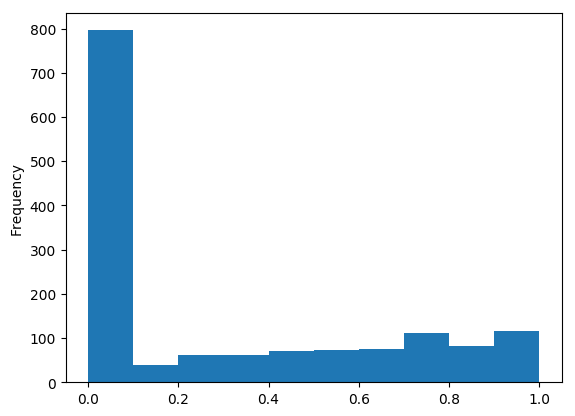

In [132]:
simMetricVals['similarity'].plot.hist()

In [126]:
# #Pickling the simMetricVals data set
simMetricVals.to_pickle("simMetricVals.pkl")

-->> Reading simMetricVals from pickle

In [127]:
#simMetricVals = pd.read_pickle("simMetricVals.pkl")

## Proxy 2: Proportion of blocking events

While our first metric (above) gives us a good sense of blocking overlaps,
it fails to show us variation in the *volume* of blocking. Some countries have more blocking than others. We want to account for that.

We'll measure the volume of blocking in each country. We'll do that by measuring, for each country, the *proportion* of observations where `censored=True`.

### Number of sites are blocked

In [31]:
NumSitesBlocked = iclabcombined.loc[(iclabcombined['censored_updated']==True),['site','country']].sort_values(by='country',ascending = False)

In [32]:
total_observations_by_country = iclabcombined.groupby('country').count()

In [33]:
total_blocked_observations_by_country = iclabcombined[iclabcombined['censored_updated']==True].groupby('country').count()

In [133]:
dummy_column_for_counting = 'dns'

def as_single_column (df):
    return df[[dummy_column_for_counting]]

def proportion (row):
    blocked = row[dummy_column_for_counting+'_blocked']
    total = row[dummy_column_for_counting+'_total']
    return blocked / total


blocking_proporitons =\
as_single_column(total_blocked_observations_by_country)\
    .merge(as_single_column(total_observations_by_country),
           on='country', suffixes=('_blocked', '_total'))\
    .apply(proportion, axis=1)

blocking_proporitons

country
AT    0.000000
AU    0.000045
BG    0.000014
BR    0.000014
BZ    0.000148
CA    0.000000
CL    0.000004
CN    0.000726
CO    0.000054
DK    0.000009
ES    0.000050
FR    0.000009
HK    0.000036
HU    0.000021
IN    0.037089
JP    0.000102
KE    0.000025
KR    0.021711
LT    0.000034
LU    0.000043
MD    0.000025
MX    0.000011
MY    0.000177
NL    0.000032
NO    0.000014
NZ    0.000036
PE    0.000047
PL    0.000665
PT    0.000008
RO    0.000033
RS    0.000042
RU    0.012843
SA    0.111579
SC    0.000021
SE    0.000008
SG    0.000014
SK    0.000169
TR    0.023203
TW    0.000030
UA    0.000714
VN    0.000024
ZA    0.000007
dtype: float64

Now we can compute the similarity in proportions between two countries.

In [134]:
def get_proportion (cc2):
    # try to retrieve it
    try:
        return blocking_proporitons[cc2]
    # if we don't have data on it
    except KeyError:
        # treat it as 0
        return 0

def compute_similarity(proportion1, proportion2):
    # keep it simple....
    # minimum and maximum values will still be 0 and 1, since we're dealing with proportions.
    return 1 - abs(proportion1 - proportion2)

CountSimilarity = []
for item in pairs:
    (country1, country2) = item
    similarity = compute_similarity(get_proportion(country1), get_proportion(country2))
    CountSimilarity.append((item, similarity))

In [135]:
blocking_proportion_similarities =\
pd.DataFrame(CountSimilarity, columns=[
    'pair',
    'proportion-similarity'
])
blocking_proportion_similarities

,pair,proportion-similarity
0,"(AD, AT)",1.000000
1,"(AD, BE)",1.000000
2,"(AD, BR)",0.999986
3,"(AD, CA)",1.000000
4,"(AD, CR)",1.000000
...,...,...
1480,"(ZA, SG)",0.999993
1481,"(ZA, SK)",0.999839
1482,"(ZA, TR)",0.976804
1483,"(ZA, TW)",0.999977


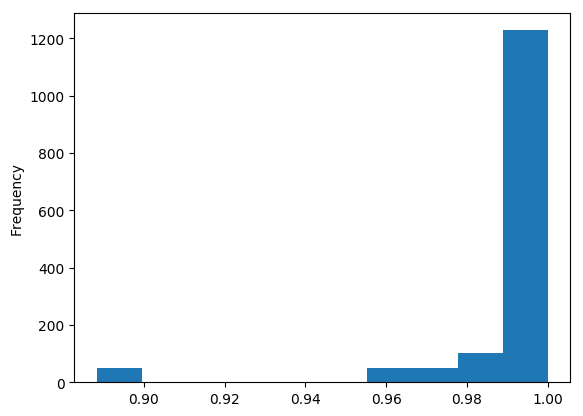

In [136]:
blocking_proportion_similarities['proportion-similarity'].plot.hist()

Not much variation here. That's okay. We'll just min-max normalize it.

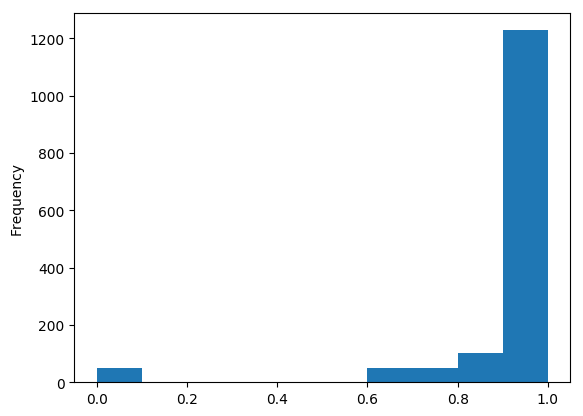

In [137]:
def min_max_norm(series):
    return (series-series.min())/(series.max()-series.min())

blocking_proportion_similarities['proportion-similarity-normalized'] = \
    min_max_norm(blocking_proportion_similarities['proportion-similarity'])
blocking_proportion_similarities['proportion-similarity-normalized'].plot.hist()

### Merging these two

In [141]:
MetricDF = pd.merge(simMetricVals,blocking_proportion_similarities,on='pair',how='outer')
MetricDF = MetricDF.rename(columns={
    'similarity':'Censored_Category_Similarity',
    'proportion-similarity-normalized':'Blocking_Proportion_Similarity',
})
MetricDF['Overall_Similarity'] = (MetricDF['Censored_Category_Similarity']+ MetricDF['Blocking_Proportion_Similarity'])/2
MetricDF = MetricDF.sort_values(by='Overall_Similarity',ascending=False)
MetricDF

,pair,country_code_alpha2_A,country_code_alpha2_B,Censored_Category_Similarity,proportion-similarity,Blocking_Proportion_Similarity,Overall_Similarity
80,"(BE, IS)",BE,IS,1.0,1.000000,1.0,1.0
1405,"(VE, IL)",VE,IL,1.0,1.000000,1.0,1.0
87,"(BE, VE)",BE,VE,1.0,1.000000,1.0,1.0
1357,"(US, CR)",US,CR,1.0,1.000000,1.0,1.0
1,"(AD, BE)",AD,BE,1.0,1.000000,1.0,1.0
...,...,...,...,...,...,...,...
570,"(IL, SA)",IL,SA,0.0,0.888421,0.0,0.0
555,"(ID, SA)",ID,SA,0.0,0.888421,0.0,0.0
209,"(CA, SA)",CA,SA,0.0,0.888421,0.0,0.0
1388,"(US, SA)",US,SA,0.0,0.888421,0.0,0.0


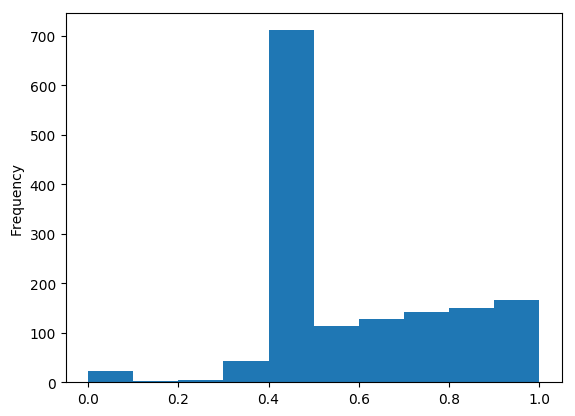

In [142]:
MetricDF['Overall_Similarity'].plot.hist()

WOW! Great variation!  Let's normalize it just to pump it a bit.

In [143]:
PercentGroup = MetricDF.Overall_Similarity.apply (lambda 
                                              x : 90 if (x>=90) 
                                              else (80 if (x>=80 and x<90)
                                                    else (70 if (x>=70 and x<80) 
                                                          else (60 if (x>=60 and x<70) 
                                                                else (50 if (x>=50 and x<60) 
                                                                      else (40 if (x>=40 and x<50) 
                                                                            else (30 if (x>=30 and x<40) 
                                                                                  else (20 if (x>=20 and x<30) 
                                                                                        else (10 if (x>=10 and x<20) 
                                                                                              else 0)  ) )  ) )) )))
                                              
                                               

In [144]:
MetricDF['PercentRangeGroup'] = PercentGroup

In [145]:
MetricDF = MetricDF.drop(columns='pair')

In [146]:
# def countryCodeConversion()

iCA = MetricDF['country_code_alpha2_A']
iCB = MetricDF['country_code_alpha2_B']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3


a3A = [countries.get(country, 'Unknown code') for country in iCA]
a3B = [countries.get(country, 'Unknown code') for country in iCB]

In [147]:
MetricDF['country_code_alpha3_A'] = a3A
MetricDF['country_code_alpha3_B'] = a3B

In [148]:
MetricDF.drop(columns=['country_code_alpha2_A','country_code_alpha2_B'],inplace=True)

In [150]:
MetricDF

,Censored_Category_Similarity,proportion-similarity,Blocking_Proportion_Similarity,Overall_Similarity,PercentRangeGroup,country_code_alpha3_A,country_code_alpha3_B
80,1.0,1.000000,1.0,1.0,0,BEL,ISL
1405,1.0,1.000000,1.0,1.0,0,VEN,ISR
87,1.0,1.000000,1.0,1.0,0,BEL,VEN
1357,1.0,1.000000,1.0,1.0,0,USA,CRI
1,1.0,1.000000,1.0,1.0,0,AND,BEL
...,...,...,...,...,...,...,...
570,0.0,0.888421,0.0,0.0,0,ISR,SAU
555,0.0,0.888421,0.0,0.0,0,IDN,SAU
209,0.0,0.888421,0.0,0.0,0,CAN,SAU
1388,0.0,0.888421,0.0,0.0,0,USA,SAU


# Outputting the JSON

Dropping other columns for JSON conversion format compliance

In [153]:
MetricDFJSON = MetricDF[['country_code_alpha3_A','country_code_alpha3_B','Overall_Similarity']]

In [154]:
MetricDFJSON.head()

,country_code_alpha3_A,country_code_alpha3_B,Overall_Similarity
80,BEL,ISL,1.0
1405,VEN,ISR,1.0
87,BEL,VEN,1.0
1357,USA,CRI,1.0
1,AND,BEL,1.0


In [157]:
pairs_of_similarities = {}
for _, row in MetricDFJSON.iterrows():
    country_pair = row.values[0] +'->'+ row.values[1]
    pairs_of_similarities[country_pair] = row.values[2]*100

In [158]:
output_json = json.dumps(pairs_of_similarities)
output_json

'{"BEL->ISL": 100.0, "VEN->ISR": 100.0, "BEL->VEN": 100.0, "USA->CRI": 100.0, "AND->BEL": 100.0, "FIN->LIE": 100.0, "FIN->ISL": 100.0, "FIN->VEN": 100.0, "FIN->ISR": 100.0, "FIN->GRC": 100.0, "FIN->DZA": 100.0, "USA->BEL": 100.0, "FIN->CZE": 100.0, "VEN->CRI": 100.0, "GRC->CRI": 100.0, "VEN->CZE": 100.0, "FIN->CRI": 100.0, "VEN->DZA": 100.0, "USA->AND": 100.0, "ISL->VEN": 100.0, "ISL->LIE": 100.0, "ISL->ISR": 100.0, "USA->ISR": 100.0, "USA->GRC": 100.0, "USA->IDN": 100.0, "BEL->LIE": 100.0, "USA->CZE": 100.0, "BEL->ISR": 100.0, "BEL->GRC": 100.0, "BEL->DZA": 100.0, "BEL->CZE": 100.0, "ISL->GRC": 100.0, "BEL->CRI": 100.0, "USA->ISL": 100.0, "USA->LIE": 100.0, "ISL->CRI": 100.0, "ISL->CZE": 100.0, "USA->VEN": 100.0, "ISL->DZA": 100.0, "USA->DZA": 100.0, "VEN->GRC": 100.0, "CRI->LIE": 100.0, "IDN->CRI": 100.0, "AND->VEN": 100.0, "DZA->GRC": 100.0, "DZA->CRI": 100.0, "IDN->BEL": 100.0, "IDN->AND": 100.0, "CZE->DZA": 100.0, "CZE->GRC": 100.0, "CZE->ISR": 100.0, "AND->LIE": 100.0, "AND->ISL"

In [159]:
with open('data.json', 'w') as outfile:
    json.dump(output_json, outfile)

In [160]:
MetricDF.to_csv("MetricDF.csv")